In [1]:
from pathlib import Path
import pandas as pd
import sys
import numpy as np
import torch
import random
import os

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt

def check_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray
        anomaly labels
    piece : int
        number of figures to separate
    threshold : float(default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(12, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = np.arange(L, R)
        if piece == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.plot(xticks, xs[L:R], color='#0C090A')
        ymin, ymax = ax.get_ylim()
        ymin = 0
        ax.set_ylim(ymin, ymax)
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                          alpha=0.6, label='true anomaly')
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()

    return fig

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from collections import Counter

def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def PA_percentile(score, label,
                  threshold=None,
                  pred=None,
                  K=100,
                  calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    anomalies = []

    for i in range(len(actual)):
        if actual[i]:
            if not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                anomalies.append([i, i])
            else:
                anomalies[-1][-1] = i
        else:
            anomaly_state = False

    for i, [start, end] in enumerate(anomalies):
        collect = Counter(predict[start:end + 1])[1]
        anomaly_count += collect
        collect_ratio = collect / (end - start + 1)

        if collect_ratio * 100 >= K and collect > 0:
            predict[start:end + 1] = True
            latency += (end - start + 1) - collect

    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, K=0, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        #predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict, latency = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        t.append(latency)
        return t
    else:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        # predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        return t


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

def bp_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-precision score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-precision
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[1] > m[1]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

In [11]:
from extract_rule_based_features import ExtractFeatures, detect_bead

In [22]:
Anode_Normal = sorted([x for x in Path("../data/230507/Anode/Normal").glob("*.csv")])
Anode_Abnormal = sorted([x for x in Path("../data/230507/Anode/Abnormal").glob("*.csv")])

data_folder_list = Anode_Normal + Anode_Abnormal
num_train_dataset = 28
Anode_Train = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','laser_active','bead_num','stamp'])
Anode_Test = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','laser_active','bead_num','stamp'])

In [ ]:
def slice_end_to_end(path):
    extractor = ExtractFeatures(path)
    data = extractor.data
    if 'Abnormal' in path:
        data['label'] = 1
        data['dataset_idx'] = path[-12:-10]
    else:
        data['label'] = 0
        data['dataset_idx'] = str(path).split('/')[-1].split('.')[0]

    bead_array = detect_bead(data['LO'])

    start = bead_array[0,0]
    end = bead_array[-1,1]
    data = data[start:end]

    data['bead_num'] = 0
    data['laser_active'] = 0

    for i in range(len(bead_array)):
        data.loc[bead_array[i][0]:bead_array[i][1],'laser_active'] = 1 # 휴지기간이 아닌 곳을 인덱싱 하기 위함
        data.loc[bead_array[i][0]:bead_array[i][1],'bead_num'] = int(i+1) # 비드 index

    return data

for i in range(num_train_dataset):
    bead_i = slice_end_to_end(str(data_folder_list[i]))    
    bead_i['stamp'] = int(i+1) #시편
    Anode_Train = pd.concat([Anode_Train, bead_i])

for i in range(num_train_dataset, len(data_folder_list)):
    bead_i = slice_end_to_end(str(data_folder_list[i]))
    bead_i['stamp'] = int(i+1)
    Anode_Test = pd.concat([Anode_Test, bead_i])

In [24]:
test_temp = Anode_Test.copy().reset_index(drop=True)

In [25]:
total_window = (len(test_temp)-25)//5+1

bead_index = []
bead_stamp = []
bead_id = []

for i in range(total_window):
    if sum(test_temp.loc[i*5:i*5+24,'laser_active'])==25: # 윈도우 안에 있는 data point가 모두 휴지 기간이 아닌 경우 
        bead_index.append(i) #휴지기간이 아닌 data point index 
        bead_stamp.append(test_temp.loc[i*5,'stamp']) # 각 비드의 시편
        bead_id.append(test_temp.loc[i*5,'bead_num']) # 각 비드의 index 

In [26]:
result = pd.read_csv('./Test_AD_results_endtoend.csv') # 모델 Inference 결과를 저장해둔 csv 파일입니다.
result.head(5)

,score,true_label
0,180.352066,0.0
1,212.830338,0.0
2,230.232071,0.0
3,235.405533,0.0
4,232.245163,0.0


In [27]:
active_beads = result.loc[bead_index] # 휴지기간을 제외한 data point indexing
active_beads['stamp'] = bead_stamp
active_beads['beads_id'] = bead_id

active_beads.reset_index(drop=True, inplace = True)

In [28]:
beads_window_mean_df = active_beads.groupby(['stamp','beads_id'])[['score','true_label']].mean().reset_index().sort_values(by=['stamp','beads_id'])

In [29]:
len(beads_window_mean_df) # 실제 비드 개수와 동일함 (=54*25)

1350

In [30]:
anomaly_score = beads_window_mean_df['score']
ground_truth = beads_window_mean_df['true_label']

In [35]:
# Best Precision
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bp_search(
                                                                score = anomaly_score,
                                                                label = ground_truth,
                                                                start = min(anomaly_score), 
                                                                end = np.percentile(anomaly_score, 95), 
                                                                step_num = 10000,
                                                                K = 100, 
                                                                verbose = False
                                                                )

print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.4987, F1: 0.2343, Precision: 1.0000, Recall: 0.1327


In [36]:
pred = (anomaly_score>threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(ground_truth, pred).ravel()
(tn, fp, fn, tp)

(378, 0, 843, 129)

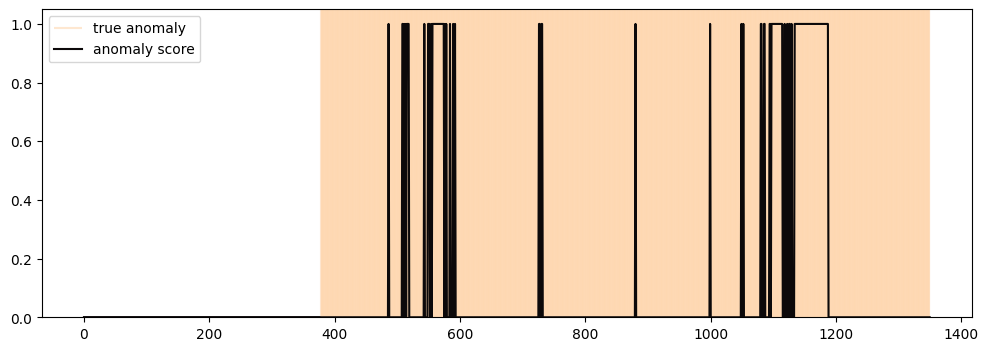

In [37]:
check_graph(pred, np.array(ground_truth))
plt.show()

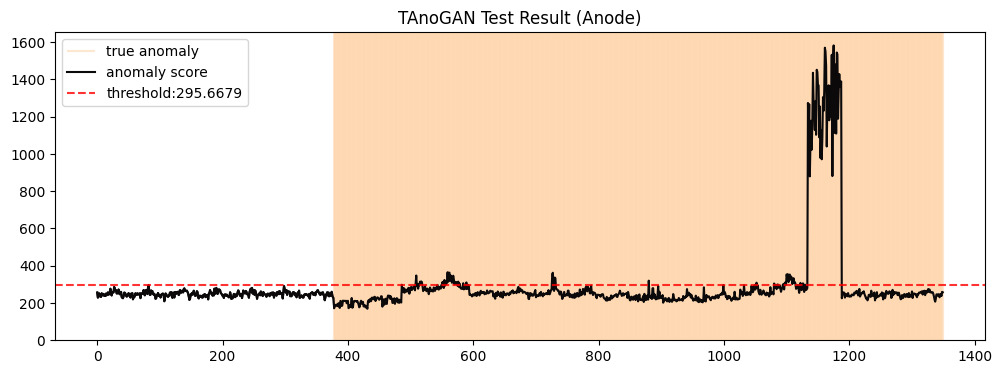

In [38]:
check_graph(np.array(anomaly_score), ground_truth,1,threshold)
plt.title('TAnoGAN Test Result (Anode)')
plt.show()